# Zygote Continued: A Differentiable Raytracer

We demonstrate in this notebook differentiating through a raytracer

In [1]:
# Initialize environment in current directory, to load
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
using RayTracer, Zygote, Flux, Images, Statistics, Interact

┌ Info: activating environment at `~/src/msr_talk/Project.toml`.
└ @ Pkg.API /Users/sabae/tmp/julia-build/julia-release-1.2/usr/share/julia/stdlib/v1.2/Pkg/src/API.jl:564


  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


┌ Info: Recompiling stale cache file /Users/sabae/.julia/compiled/v1.2/RayTracer/sUryZ.ji for RayTracer [60dacb86-48ff-11e9-0f01-03ab8794bbc9]
└ @ Base loading.jl:1240


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-3042182128585051682\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-9960075925948293446\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/de9d19b6ee19a3761cb5e9ef3b8ac4aba26fecb6-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-3042182128585051682\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

In [2]:
width = 200
height = 200

# Static camera configuration 
cam = Camera(
    # Center
    Vec3(0.0f0, 0.0f0, -5.0f0),
    # Target
    Vec3(0.0f0, 0.0f0,  0.0f0),
    # Up
    Vec3(0.0f0, 1.0f0, 0.0f0),
    # Field of View
    45.0f0,
    # Focus
    1.0f0,
    # Resolution
    width, height,
)
origin, direction = get_primary_rays(cam)

function render(scene, light)
    packed_image = raytrace(origin, direction, scene, light, origin, 0)
    array_image = reshape(hcat(packed_image.x, packed_image.y, packed_image.z), (width, height, 3, 1))
    return array_image
end

function showimg(img)
    return colorview(RGB, permutedims(img[:,:,:,1], (3,2,1)))
end

showimg (generic function with 1 method)

In [3]:
# Simple scene with two triangles
scene_gt = [
    Triangle(
        Vec3(-1.7f0,  1.0f0, 0.0f0),
        Vec3( 1.0f0,  1.0f0, 0.0f0),
        Vec3(-0.5f0, -1.0f0, 0.0f0),
        color = rgb(0.0f0, 1.0f0, 0.0f0),
        reflection = 0.5f0,
    ),
    Triangle(
        Vec3(0.0f0,  0.3f0, -1.0f0),
        Vec3(1.6f0,  0.0f0, -0.9f0),
        Vec3(1.3f0, -0.8f0, -0.5f0),
        color = rgb(1.0f0, 0.0f0, 0.0f0),
        reflection = 0.4f0,
    ),
]


@manipulate for light_x in -10:0.1f0:10,
                light_y in -10:0.1f0:10
    global light_gt, image_gt, scene_gt
    
    light_gt = PointLight(
        # Color
        Vec3(1.0f0, 1.0f0, 0.0f0),
        # Intensity
        20000.0f0,
        # Position
        Vec3(light_x, light_y, -10.0f0)
    )

    image_gt = render(scene_gt, light_gt)
    showimg(image_gt)
end

┌ Info: Recompiling stale cache file /Users/sabae/.julia/compiled/v1.2/QuartzImageIO/n8vDP.ji for QuartzImageIO [dca85d43-d64c-5e67-8c65-017450d5d020]
└ @ Base loading.jl:1240


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope("knockout-component-c38aaa86-25c9-4f6a-bff6-d43e1ca05fc1", Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["light_x"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:className => "interact-flex-row-left"), 2), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 201,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:className => "interact-flex-row-center"), 1), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")), 0)], Dict{Symbol,Any}(:className => "interact-flex-row-right"), 1)], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget"), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
101, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/sabae/.julia/packages/Knockout/JE2Yq/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/sabae/.julia/packages/Knockout/JE2Yq/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/sabae/.julia/packages/InteractBase/R8JgH/src/../assets/all.js"), Asset("css", nothing, "/Users/sabae/.julia/packages/InteractBase/R8JgH/src/../assets/style.css"), Asset("css", nothing, "/Users/sabae/.julia/packages/Interact/0klKX/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:9223372036854775807,sz_curr:0), Set(AbstractConnection[]), Channel{AbstractConnection}(sz_max:32,sz_curr:0)), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"-10.0\",\"-9.9\",\"-9.8\",\"-9.7\",\"-9.6\",\"-9.5\",\"-9.4\",\"-9.3\",\"-9.2\",\"-9.1\",\"-9.0\",\"-8.9\",\"-8.8\",\"-8.7\",\"-8.6\",\"-8.5\",\"-8.4\",\"-8.3\",\"-8.2\",\"-8.1\",\"-8.0\",\"-7.9\",\"-7.8\",\"-7.7\",\"-7.6\",\"-7.5\",\"-7.4\",\"-7.3\",\"-7.2\",\"-7.1\",\"-7.0\",\"-6.9\",\"-6.8\",\"-6.7\",\"-6.6\",\"-6.5\",\"-6.4\",\"-6.3\",\"-6.2\",\"-6.1\",\"-6.0\",\"-5.9\",\"-5.8\",\"-5.7\",

# Training loop

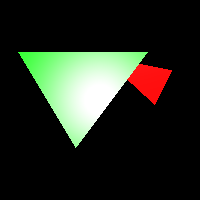

In [4]:
# Start out the `light` at an incorrect position
light = PointLight(Vec3(1.0f0, 1.0f0, 0.0f0), 20000.0f0, Vec3(0.0f0, 0.0f0, -11.0f0))

scene = [
    Triangle(
        Vec3(-1.7f0,  1.0f0, 0.0f0),
        Vec3( 1.0f0,  1.0f0, 0.0f0),
        Vec3(-0.5f0, -1.0f0, 0.0f0),
        color = rgb(0.0f0, 1.0f0, 0.0f0),
        reflection = 0.6f0,
    ),
    Triangle(
        Vec3(0.0f0,  0.3f0, -1.0f0),
        Vec3(1.6f0,  0.0f0, -0.9f0),
        Vec3(1.3f0, -0.8f0, -0.5f0),
        color = rgb(1.0f0, 0.0f0, 0.0f0),
        reflection = 0.4f0,
    ),
]

showimg(render(scene, light))

loss = 0.003516449f0


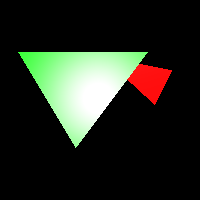

┌ Info: 1 iterations completed
└ @ Main In[5]:26


loss = 0.0035046989f0
loss = 0.003466695f0
loss = 0.0034169175f0
loss = 0.0033550896f0
loss = 0.0032816264f0
loss = 0.0032044f0
loss = 0.0031147993f0
loss = 0.0030166926f0
loss = 0.0029100836f0
loss = 0.002786581f0


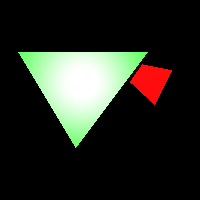

┌ Info: 11 iterations completed
└ @ Main In[5]:26


loss = 0.0026639346f0
loss = 0.002522308f0
loss = 0.0023874852f0
loss = 0.0022445768f0
loss = 0.0020946297f0
loss = 0.0019481931f0
loss = 0.001802167f0
loss = 0.0016537956f0
loss = 0.0015236647f0
loss = 0.001394169f0


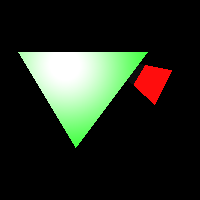

┌ Info: 21 iterations completed
└ @ Main In[5]:26


loss = 0.0012726664f0
loss = 0.0011652499f0
loss = 0.0010617966f0
loss = 0.0009654896f0
loss = 0.0008761051f0
loss = 0.00079300377f0
loss = 0.00071916246f0
loss = 0.00064828584f0
loss = 0.0005827715f0
loss = 0.0005274295f0


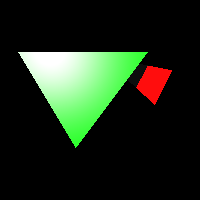

┌ Info: 31 iterations completed
└ @ Main In[5]:26


loss = 0.00047154093f0
loss = 0.0004199794f0
loss = 0.00037773474f0
loss = 0.00034160906f0
loss = 0.00030153667f0
loss = 0.00027369193f0
loss = 0.00023928605f0
loss = 0.00021451578f0
loss = 0.00018849276f0
loss = 0.00016743841f0


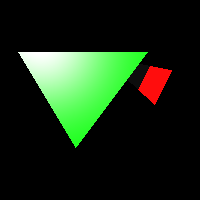

┌ Info: 41 iterations completed
└ @ Main In[5]:26


loss = 0.0001422946f0
loss = 0.00012642727f0
loss = 0.000108912645f0
loss = 9.2363865f-5
loss = 7.9204954f-5
loss = 6.66316f-5
loss = 7.0524184f-5
loss = 7.476473f-5
loss = 8.3510684f-5
loss = 9.0613794f-5


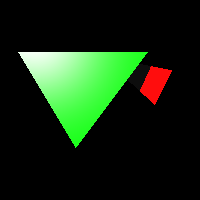

┌ Info: 51 iterations completed
└ @ Main In[5]:26


In [5]:
opt = ADAM(0.1)
image_gt = render(scene_gt, light_gt)
showimg(image_gt)

for i in 1:51
    # Take gradient of the following function
    grads = gradient(scene, light) do S, L
        # First, render according to our current light and scene
        image_rendered = render(S, L)
        
        # Normalize 
        loss = mean((zeroonenorm(image_rendered) .- zeroonenorm(image_gt)).^2)
        
        # Show the current loss
        @show loss
        
        # Return this loss as what is to be minimized
        return loss
    end
    
    # Update our light position and triangle color based upon those gradients
    #update!(opt, scene[1].material.color.color, grads[1][1].material.color.color)
    update!(opt, light.position, grads[2].position)
    
    if i % 10 == 1
        @info "$i iterations completed"
        display(showimg(render(scene, light)))
    end
end


In [29]:
light_gt

PointLight{Float32}(Vec3{Array{Float32,1}}(Float32[1.0], Float32[1.0], Float32[0.0]), 20000.0f0, Vec3{Array{Float32,1}}(Float32[3.6], Float32[3.0], Float32[-10.0]))

In [30]:
light

PointLight{Float32}(Vec3{Array{Float32,1}}(Float32[1.0], Float32[1.0], Float32[0.0]), 20000.0f0, Vec3{Array{Float32,1}}(Float32[4.18166], Float32[2.4189723], Float32[-9.362359]))